<a href="https://colab.research.google.com/github/Sanford-Lab/satellite_cnns/blob/main/benin_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook uses a dataset of Benin to train a model to predict which pixels belong to a village. The dataset takes in the feature collection from 'projects/satellite-cnns/assets/benin/voronoi_villages' which has circles around villages in Benin and uses this as a target for prediction. As input, the landsat 7 imagery of Benin is used.

The notebook has the sections:

1.   Setup & General settings
2.   Read data




**NOTES:**

*   The Benin prediction problem is a segmentation task.


> YB: Classification: Currently, the model predicts a pixel-wise classification. We wondered whether this is really necessary since our ground truth is captured in larger patches. Therefore, it might be sufficient to predict one value for a rectangle and take care of the border areas by combining the values of all relevant rectangles. If we use pixel-wise predictions, the model might simply learn how to draw borders. Could you explain why pixel-wise classification makes sense in the case of Benin? Maybe we are overlooking an important aspect also for the Kenyan case…

> DD: [... F]or Benin we need it because we need to both predict treatment status and outcomes, and use residuals from both of those models. For each even a relatively small tile size is much larger than the spatial scale of interest.





# 1. Setup & General settings

## 1.1 Setup

In [ ]:
%rm -r /content/satellite_cnns
%cd /content

In [2]:
branch = "main"

In [ ]:
# Clone from SPIRES Repo
!git clone --branch {branch} https://github.com/Sanford-Lab/satellite_cnns.git
%cd /content/satellite_cnns

**New**: The notebook now sources files from the Sanford-Lab/satellite_cnns repo. For this notebook, it will use the `benin-data` package. It's built it based on the weather-forcasting notebook patterns and to allow importing for project-specific packages to *plug and play* for data creation. The new patterns should allow the workflow to be much more modular. All a new project would need to do is define 3 main functions `get_inputs_image`, `get_labels_image`, and `sample_points`. The create_dataset.py script should then be able to synthesize the dataset through abstraction. I've kept most of the demonstration functionality the same to show how using the package works.

In [ ]:
!pip install --quiet --upgrade pip

# We need `build` and `virtualenv` to build the local packages.
!pip install --quiet build virtualenv

# Install Apache Beam and the `benin-data` local package.
!pip install apache-beam[gcp] src/benin-data

In [5]:
# run to manually restart runtime by ending process
# exit()

## 1.2 General settings

At this point runtime is restarted. Navigate back to our working directory.

In [ ]:
%cd /content/satellite_cnns

In [2]:
#@title Project settings
from __future__ import annotations

import os
from google.colab import auth

auth.authenticate_user()

# Please fill in these values.
project = "satellite-cnns" #@param {type:"string"}
bucket = "beninbucket" #@param {type:"string"}
location = "us-central1" #@param {type:"string"}

# Quick input validations.
assert project, "⚠️ Please provide a Google Cloud project ID"
assert bucket, "⚠️ Please provide a Cloud Storage bucket name"
assert not bucket.startswith('gs://'), f"⚠️ Please remove the gs:// prefix from the bucket name: {bucket}"
assert location, "⚠️ Please provide a Google Cloud location"

# Authenticate to Colab.
auth.authenticate_user()

# Set GOOGLE_CLOUD_PROJECT for google.auth.default().
os.environ['GOOGLE_CLOUD_PROJECT'] = project

# Set the gcloud project for other gcloud commands.
!gcloud config set project {project}

Updated property [core/project].


In [3]:
import ee
import google.auth

credentials, _ = google.auth.default()
ee.Initialize(
    credentials.with_quota_project(None),
    project=project,
    opt_url="https://earthengine-highvolume.googleapis.com",
)

# 2. Read data


## 2.1 Google Cloud Storage

Let's check Google Cloud Storage to see the files in GC

In [ ]:
bucket = 'beninbucket'
folder = 'yb_test'
data_path=f"gs://{bucket}/{folder}/data"
print(data_path)
!gsutil ls -lh {data_path}

Next, let's copy the files to a local directory to look at them

In [ ]:
!mkdir -p data-training
!gsutil -m cp {data_path}/* data-training

In [6]:
# Use this to wipe the folder if needed
#%rm -r data-training

## 2.2 Look at dataset

In [7]:
import torch
from read_data import DatasetFromPath

dataset = DatasetFromPath('data-training')

**Note**: to avoid using [Hugging Face 🤗 Datasets](https://huggingface.co/docs/datasets/main/en/index) (like in the weather forcasting sample), we're going to use a custom subclass of PyTorch's `torch.utils.data.Dataset` (`DatsetFromPath`). Hugging Face is nice to use a high-level interface for using datasets and should maybe be implemented in the future, but as of this writing (7/4/2023), VertexAI (what we're using for cloud training) has an issue with it's Hugging Face Trainer API (see [weather sample issue](https://github.com/GoogleCloudPlatform/python-docs-samples/issues/9272)).

### Visualize

Let's grab the dataset (`data`) from our path (`/content/data_training`) and pull the top element from the dataset as `example`. In `DatasetFromPath`, the custom getter utilizes dictionary keys of `inputs` and `labels`, so to grab the inputs of example, we use `example['inputs']`.

Check what was run through the pipeline. You should expect to see:
- Dataset size of 2 * `POINTS_PER_CLASS`
- inputs size of (`PATCH_SIZE`, `PATCH_SIZE`, number of input bands)
- labels size of (`PATCH_SIZE`, `PATCH_SIZE`, number of label bands)

In [8]:
print(f"Dataset size: {len(dataset)}")
example = dataset[0]  # random access the first element

print(f"inputs: {example['inputs'].shape}")
print(f"labels: {example['labels'].shape}")

Dataset size: 1000
inputs: (128, 128, 5)
labels: (128, 128, 1)


The `DatsetFromPath` class also allows you to retrieve all of the inputs/labels in a dataset in their raw NumPy array form by indexing with "inputs" or "labels":

In [9]:
inputs = dataset['inputs']
labels = dataset['labels']

print(f"All inputs: {inputs.shape}")
print(f"All labels: {labels.shape}")

All inputs: (1000, 128, 128, 5)
All labels: (1000, 128, 128, 1)


Let's view our example using our visualization functionality. For Benin, blue = inside village, red = outside village.

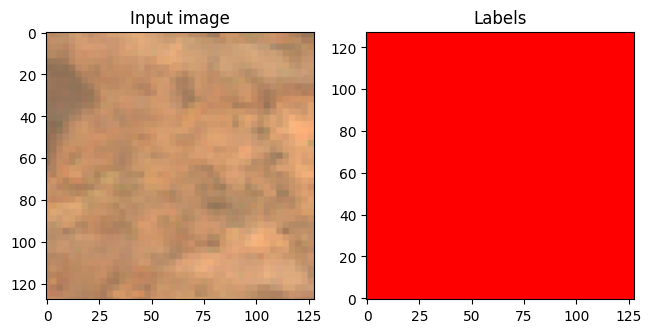

In [10]:
from visualize import show_patch


inputs = example['inputs']
labels = example['labels']

show_patch(inputs, labels)

How let's split the dataset into a train and test subset using the test_train_split function. Test differt ratios to see how the dataset splits and view the first of each.

Train size: 800
inputs: (128, 128, 5)
labels: (128, 128, 1)
Test size: 200
inputs: (128, 128, 5)
labels: (128, 128, 1)

Train[0]:


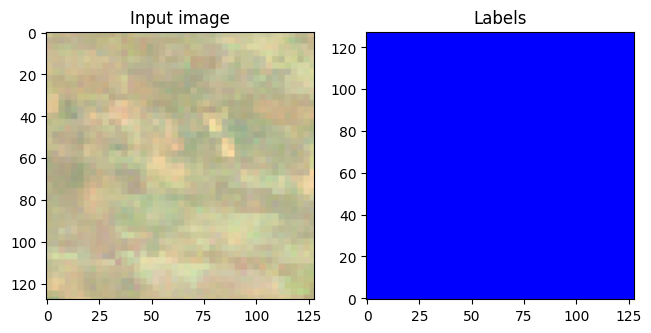

Test[0]:


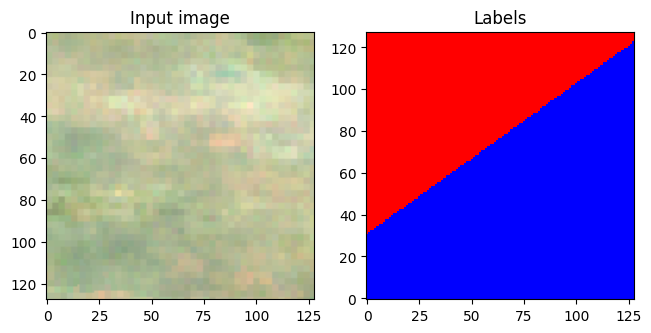

In [11]:
from read_data import train_test_split
train, test = train_test_split(dataset)

print(f"Train size: {len(train)}")
train_example = train[0]  # random access the first element
print(f"inputs: {train_example['inputs'].shape}")
print(f"labels: {train_example['labels'].shape}")
print(f"Test size: {len(test)}")
test_example = test[0]  # random access the first element
print(f"inputs: {test_example['inputs'].shape}")
print(f"labels: {test_example['labels'].shape}\n")

train_inputs = train_example['inputs']
train_labels = train_example['labels']
test_inputs = test_example['inputs']
test_labels = test_example['labels']
print(f'Train[0]:')
show_patch(train_inputs, train_labels)
print(f'Test[0]:')
show_patch(test_inputs, test_labels)

# 3. Helper functions

**To Do:** Include normalisation, definition of transform containers and get_loaders into `read_data.py`.

## 3.1 Transformers

In [12]:
def prep_normalize(dataset):
  # Access inputs in dataset
  inputs = dataset['inputs']

  # Reshape to (num_inputs * num_pixels, num_bands)
  reshaped_inputs = inputs.reshape(-1, inputs.shape[-1])

  # Calculate mean, std and max for each band across all inputs
  means = reshaped_inputs.mean(axis=0)
  stds = reshaped_inputs.std(axis=0)

  return {'mean': means.tolist(), 'std': stds.tolist()}

NORM_TRAIN = prep_normalize(train)
print("Train:", NORM_TRAIN)
NORM_TEST = prep_normalize(test)
print("Test:", NORM_TEST)

Train: {'mean': [0.1203223392367363, 0.10668385773897171, 0.07152701914310455, 0.2450847029685974, 0.35134872794151306], 'std': [0.026951653882861137, 0.015993449836969376, 0.01145727839320898, 0.031813498586416245, 0.10061567276716232]}
Test: {'mean': [0.11723122745752335, 0.10059080272912979, 0.07786951214075089, 0.24046039581298828, 0.347533643245697], 'std': [0.026567844673991203, 0.014292296022176743, 0.009704279713332653, 0.02885521575808525, 0.09489502757787704]}


In [13]:
from torchvision.transforms import v2

# -------------------------------------------------------------------- #
# Apply image augmention and adjust labels (e.g. after flipping image)
# -------------------------------------------------------------------- #

# Specify transforms for training
TRANSFORM_TRAIN = v2.Compose([
    v2.RandomHorizontalFlip(),  # default value is p=0.5
    v2.RandomVerticalFlip(),    # default value is p=0.5
    v2.Normalize(
        mean=NORM_TRAIN['mean'],
        std=NORM_TRAIN['std'])
    ])

# Specify transforms for testing
TRANSFORM_TEST = v2.Compose([
    v2.Normalize(
        mean=NORM_TEST['mean'],
        std=NORM_TEST['std'])
])

---------- Original ----------


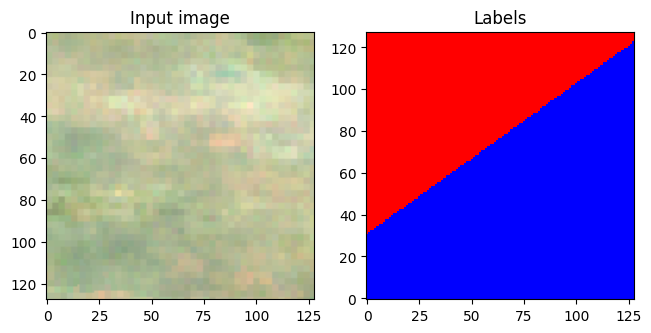

---------- Horizontal Flip ----------


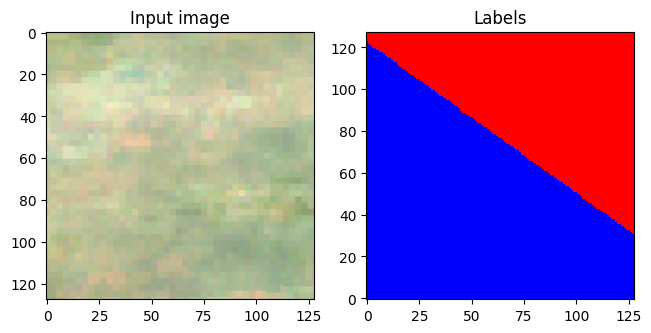

---------- Vertical Flip ----------


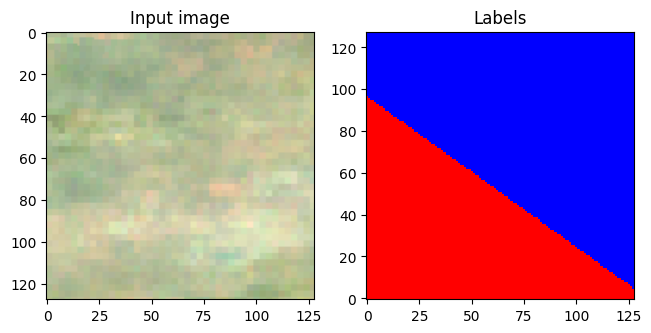

In [14]:
# Examples for transforms
transform_example1 = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(p=1)
])

transform_example2 = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomVerticalFlip(p=1)
])

print("---------- Original ----------")
show_patch(test_inputs, test_labels)

print("---------- Horizontal Flip ----------")
test_inputs_ex1, test_labels_ex1 = transform_example1(test_inputs, test_labels)
test_inputs_ex1 = test_inputs_ex1.permute(1,2,0).numpy()
test_labels_ex1 = test_labels_ex1.permute(1,2,0).numpy()
show_patch(test_inputs_ex1, test_labels_ex1)

print("---------- Vertical Flip ----------")
test_inputs_ex2, test_labels_ex2 = transform_example2(test_inputs, test_labels)
test_inputs_ex2 = test_inputs_ex2.permute(1,2,0).numpy()
test_labels_ex2 = test_labels_ex2.permute(1,2,0).numpy()
show_patch(test_inputs_ex2, test_labels_ex2)

## 3.2 Data Loader

In [15]:
from torch.utils.data import DataLoader
TEST_TRAIN_RATIO = 0.8

def get_loaders(
    path,
    batch_size,
    ratio = TEST_TRAIN_RATIO,
    transform_train=None,
    transform_test=None,
    num_workers = 2,
    pin_memory = True
):

  # Load dataset
  dataset = DatasetFromPath(path)

  # Define transformers
  transform_dict = None
  if transform_train or transform_test:
    transform_dict = {'train': transform_train, 'test': transform_test}

  # Split into training and testing dataset
  train, test = train_test_split(dataset, ratio=ratio, transform_dict=transform_dict)
  print(f"Train inputs: {train[0]['inputs'].shape}")
  print(f"Train labels: {train[0]['labels'].shape}")
  print(f"Test inputs: {test[0]['inputs'].shape}")
  print(f"Test labels: {test[0]['labels'].shape}")

  # Initialize data loaders
  train_loader = DataLoader(
      train,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle=True)

  test_loader = DataLoader(
      test,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle=True)

  return train_loader, test_loader

In [16]:
train_loader, test_loader = get_loaders(path='data-training', batch_size=8, transform_train=TRANSFORM_TRAIN, transform_test=TRANSFORM_TEST)

Train inputs: torch.Size([5, 128, 128])
Train labels: torch.Size([1, 128, 128])
Test inputs: torch.Size([5, 128, 128])
Test labels: torch.Size([1, 128, 128])


In [17]:
print("Inputs - Size of the first training batch:", next(iter(train_loader))['inputs'].shape)
print("Labels - Size of the first training batch:", next(iter(train_loader))['labels'].shape)

Inputs - Size of the first training batch: torch.Size([8, 5, 128, 128])
Labels - Size of the first training batch: torch.Size([8, 1, 128, 128])
